In [384]:
import numpy as np
import re
import cv2
import imutils
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [2]:
model = load_model('D:/Intelliza_Projects/TPL/OCR/meter_ocr/stmeter_ocr_emnist_customdata.h5')

In [4]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

In [413]:
def clean_pole_no(number):
    pattern = "(?P<char>[" + re.escape('/') + "])(?P=char)+"
    a = re.sub(pattern, r'\1', number)
    clean_number = re.sub('(^/|/$)', '', a)
    return clean_number

In [414]:
def get_sorted_contours(contours, image_width):
    bboxes = []
    #area = []
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        #if int(image_width/2 *0.5) <= x+(w/2) <= int(image_width/2*1.50):
        if int(image_width/2 *0.6) <= x+(w/2) <= int(image_width/2*1.4):
            bboxes.extend([x, y, w, h, int(x+(w/2)), int(y+(h/2)), (w*h)])
            #area.append(w*h)
    
    bboxes = np.reshape(np.asarray(bboxes), (-1, 7))

    # applying Non-maximum Suppression to remove overlapping bounding boxes
    nms_bboxes = non_max_suppression(bboxes, 0.3)
    
    # Calculate mean area of the bounding boxes
    average_area = np.mean(np.asarray(nms_bboxes[:, 6]))
    
    sorted_bboxes = sorted(nms_bboxes, key=lambda nms_bboxes:[nms_bboxes[5], nms_bboxes[4]])
    
     # Sort the bounding boxes top-to-bottom then left-to-right
    for i in range(0, len(sorted_bboxes)):
        for j in range(0, len(sorted_bboxes)):
            if int(sorted_bboxes[j][5]*0.9) <= sorted_bboxes[i][5] <= int(sorted_bboxes[j][5]*1.10):
                if sorted_bboxes[i][4] < sorted_bboxes[j][4]:
                    temp = sorted_bboxes[i]
                    sorted_bboxes[i] = sorted_bboxes[j]
                    sorted_bboxes[j] = temp 
    
    return sorted_bboxes, average_area

In [415]:
def non_max_suppression(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + boxes[:,2]
    y2 = boxes[:,1] + boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        
        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]
            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)
        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
    # return only the bounding boxes that were picked
    return boxes[pick]

In [428]:
def get_stmeter_no(imagepath):
    
    # Create empty array to store entire number
    full_number = []

    # Read the streetlight image
    image = cv2.imread(imagepath)
    
    # Convert the image to grayscale, and blur it to reduce noise
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    blurred = cv2.fastNlMeansDenoising(gray, None, 31, 7, 21)
    
    # Perform edge detection, find contours in the edge map, and sort the resulting contours from top-to-bottom
    edged = cv2.Canny(blurred, 30, 25)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="top-to-bottom")[0]
    
    # Initialize the list of contour bounding boxes and associated characters that we'll be OCR'ing
    chars = []
    
    # Sort the contours from top to bottom and then left to right if they are in same line
    rect, avg_area = get_sorted_contours(cnts, image.shape[1])
    
    # Loop over the sorted bounding boxes
    for r in rect:
        # Compute the bounding box of the contour
        x = r[0]
        y = r[1]
        w = r[2]
        h = r[3]
        
        # extract the character and threshold it to make the character appear as *white* (foreground) on a *black* background, 
        # then grab the width and height of the thresholded image
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1] 
        (tH, tW) = thresh.shape
            # if the width is greater than the height, resize along the width dimension
            
        if tW > tH:
            thresh = imutils.resize(thresh, width=32)
            # otherwise, resize along the height
        else:
            thresh = imutils.resize(thresh, height=32)
                              
            # re-grab the image dimensions (now that its been resized) and then determine how much we need to pad the width and
            # height such that our image will be 32x32
        (tH, tW) = thresh.shape
        dX = int(max(0, 32 - tW) / 2.0)
        dY = int(max(0, 32 - tH) / 2.0)
        
            # pad the image and force 32x32 dimensions
        padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
        left=dX, right=dX, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
        padded = cv2.resize(padded, (32, 32))
        
        # prepare the padded image for classification via our handwriting OCR model
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)
        
        # update our list of characters that will be OCR'd
        chars.append((padded, (x, y, w, h)))
            
    # extract the bounding box locations and padded characters
    boxes = [b[1] for b in chars]
    chars = np.array([c[0] for c in chars], dtype="float32")

    # OCR the characters using our handwriting recognition model
    preds = model.predict(chars)
    
    for (pred, (x, y, w, h)) in zip(preds, boxes):
    # find the index of the label with the largest corresponding
    # probability, then extract the probability and label
        i = np.argmax(pred)
        prob = pred[i]
        label = labelNames[i]
       
        if (prob * 100 > 30) and (w*h > avg_area*0.25):
                
            # draw the prediction on the image
            aspect_ratio = w / h
            
            if aspect_ratio > 3:
                full_number.append('/')
                continue
            elif aspect_ratio < 0.05:
                full_number.append('1')
            else:                
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                full_number.append(label)
    
    full_number = [''.join(full_number)][0]
    
    pole_number = clean_pole_no(full_number)
    
    #print(f'Pole No: {full_number}')
    print(f'Pole No: {pole_number}')
    
    return image

Pole No: C/29/17/10


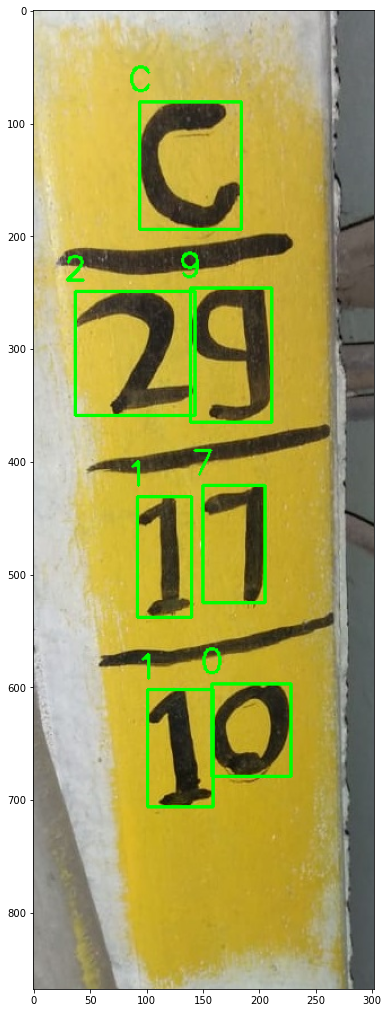

In [446]:
imagepath = 'D:\\Intelliza_Projects\\TPL\\OCR\\meter_ocr\\streetlight_images\\cropped\\2.jpg'

meter_no = get_stmeter_no(imagepath)

plt.figure(figsize=(22,18))
img = cv2.cvtColor(meter_no, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()